# 神州极客大赛  智能定价

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import StratifiedKFold,KFold


# 导入需要的模块

import matplotlib.pyplot as plt

# 用来绘图的，封装了matplot
# 要注意的是一旦导入了seaborn，
# matplotlib的默认作图风格就会被覆盖成seaborn的格式
import seaborn as sns       

from scipy import stats
from scipy.stats import  norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  
# 为了在jupyter notebook里作图，需要用到这个命令

## EDA

In [2]:
data_path = r'data/整车运输智能定价-初赛数据.xlsx'
train_data = pd.read_excel(data_path,sheet_name='训练集')
test_data = pd.read_excel(data_path,sheet_name='测试集')
train_data.loc[:,"index"] = 0

In [3]:
train_data

,报价编号,距离km,车型,起始城市,目的城市,车长,车宽,车高,标准载重,车辆容积,货物类型,用车时间,货物特性,运输要求,备注,车价,index
0,XJ2022041400009,559.18,微型面包车,陕西省,陕西省,1.8,1.3,1.1,0.5,1.6,一般货物,2022-04-15 10:00:00,NaN,NaN,货物共计18件，160公斤，库房内装车，按照客户要求货物卸到指定位置，返回单,77.78,0
1,2021102000011,67.17,7.6米厢车,重庆市,重庆市,7.6,2.3,2.5,9.8,34.0,高值货物,2021-10-20 14:44:08,NaN,NaN,NaN,81.48,0
2,2021111100008,548.07,4.2米厢车,济南市,田家庵区,4.2,1.8,1.8,3.0,12.0,高值货物,2021-11-11 17:21:54,NaN,NaN,项目要求使用9.6和4.2货车各1辆，约600公里。,74.07,0
3,XJ2022042000004,263.95,16.5米厢车,福州市,漳州市,16.5,2.5,2.8,28.0,100.0,超重货物,2022-04-20 13:57:00,NaN,NaN,NaN,129.63,0
4,2022012500017,175.97,高顶依维柯,上海市,浙江省,2.3,1.6,1.6,1.0,4.0,超重货物,2022-01-25 16:53:00,NaN,NaN,费用含装卸，一装两卸，单件货物比较大最好两个人送货，还要有手拉车，因为要上楼,62.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,2021093000002,805.03,5.2米厢车,上海市,山东省,5.2,2.2,2.5,5.0,20.0,一般货物,2021-09-30 00:06:30,NaN,NaN,立即用车需求 提货直发 上海普陀真沃路348号-山东省济南市市中区白马山南路8号 国家粮食储...,118.52,0
2625,2022030400013,121.72,4.2米厢车,北京市,天津市,4.2,1.8,1.8,3.0,12.0,一般货物,2022-03-05 10:00:00,NaN,NaN,1、需要装卸，末端要按型号分货交接，末端需要逐台验收，交货等待时间约三小时。2、附件出仓单，...,29.63,0
2626,2021091600004,132.93,4.2米厢车,北京市,天津市,4.2,1.8,1.8,3.0,12.0,高值货物,2021-09-16 13:00:00,NaN,NaN,1、包车预约配送；2、需要装卸；3、需按照签收要求签回指定附件。电池SN: 05FPEP06...,28.89,0
2627,2021111800018,940.03,6.8米平板,宝鸡市,汶上县,6.8,2.0,NaN,9.0,35.0,一般货物,2021-11-19 23:59:58,NaN,"需雨布,走高速,司机五证齐全",按时送达，回单签收寄回,185.19,0


In [4]:
test_data.loc[:,"index"] = 1

In [5]:
data_all = pd.concat([train_data, test_data])

In [6]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2929 entries, 0 to 299
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   报价编号    2929 non-null   object 
 1   距离km    2929 non-null   float64
 2   车型      2929 non-null   object 
 3   起始城市    2929 non-null   object 
 4   目的城市    2929 non-null   object 
 5   车长      2929 non-null   float64
 6   车宽      2879 non-null   float64
 7   车高      2863 non-null   float64
 8   标准载重    2925 non-null   float64
 9   车辆容积    2929 non-null   float64
 10  货物类型    2927 non-null   object 
 11  用车时间    2929 non-null   object 
 12  货物特性    72 non-null     object 
 13  运输要求    574 non-null    object 
 14  备注      2026 non-null   object 
 15  车价      2929 non-null   float64
 16  index   2929 non-null   int64  
dtypes: float64(7), int64(1), object(9)
memory usage: 411.9+ KB


In [7]:
data_all['车价'].describe()

count    2929.000000
mean      173.685760
std       187.608694
min         2.960000
25%        33.330000
50%        96.300000
75%       259.260000
max      1481.480000
Name: 车价, dtype: float64

In [15]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei',font_scale=1.5)  # 解决Seaborn中文显示问题并调整字体大小

<AxesSubplot:xlabel='车价', ylabel='Density'>

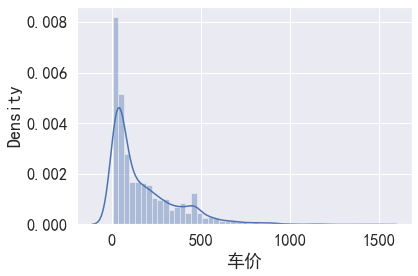

In [16]:
sns.distplot(data_all['车价'])

(-0.5, 17.5, 0.0, 1500.0)

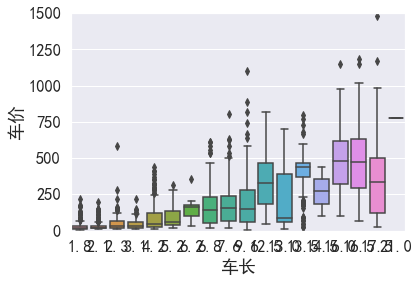

In [17]:
# CentralAir
var = '车长'
data = pd.concat([data_all['车价'], data_all[var]], axis=1)
fig = sns.boxplot(x=var, y="车价", data=data)
fig.axis(ymin=0, ymax=1500)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='距离km', ylabel='车价'>

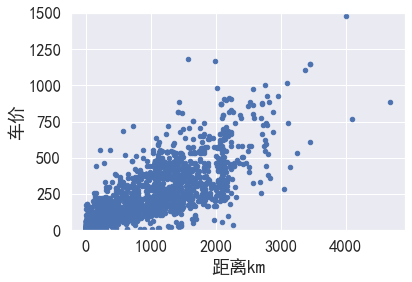

In [18]:
# YearBuilt  scatter
var = '距离km'
data = pd.concat([data_all['车价'], data_all[var]], axis=1)
data.plot.scatter(x=var, y="车价", ylim=(0, 1500))

<AxesSubplot:>

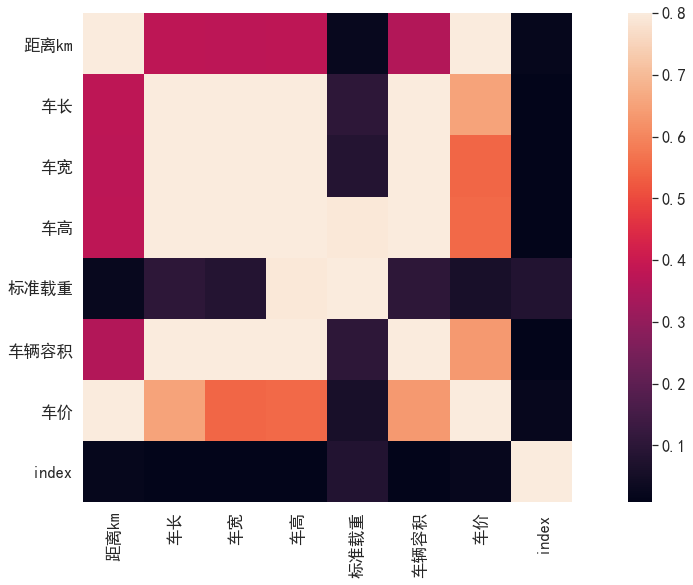

In [19]:
corrmat = data_all.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

### 缺失值分析

In [20]:
all_data_na = (data_all.isnull().sum() / len(data_all)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
货物特性,97.541823
运输要求,80.402868
备注,30.829635
车高,2.253329
车宽,1.707067
标准载重,0.136565
货物类型,0.068283


Text(0.5, 1.0, 'Percent missing data by feature')

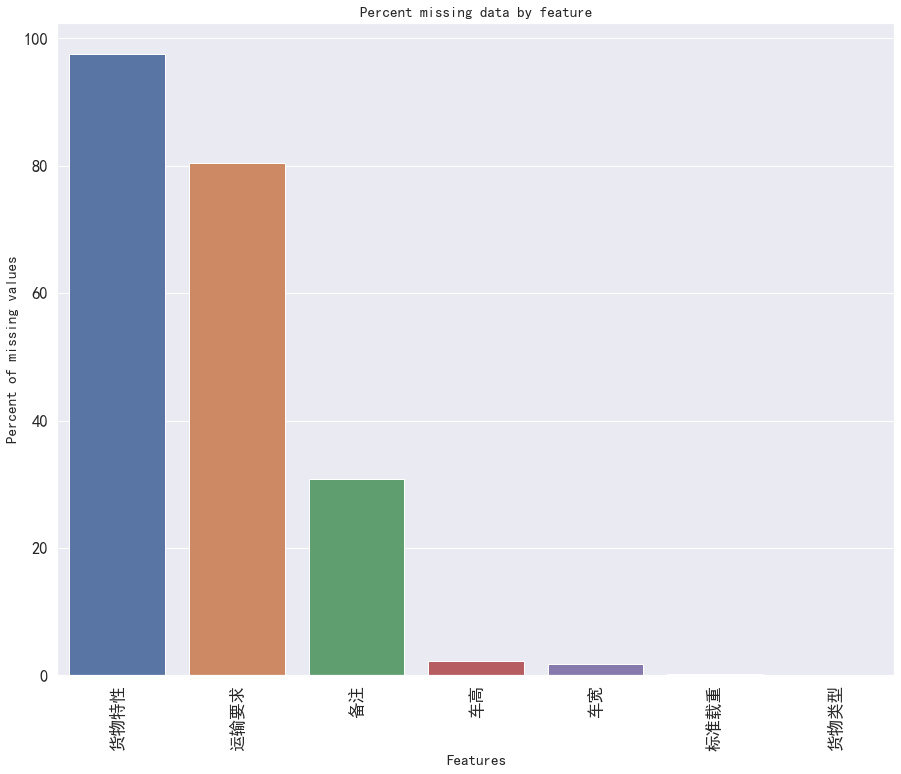

In [21]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [22]:
scenes = data_all["货物特性"].unique().tolist()
scenes

[nan,
 '超高',
 '超重',
 '禁区',
 '超重,超高',
 '超重,禁区',
 '超高,超宽',
 '超重,超高,超长',
 '超宽',
 '超重,超长',
 '超长',
 '超重,超高,超长,超宽,禁区']

In [23]:
 data_all["货物特性"].count()

72

## 特征工程

In [8]:
for feat in data_all.columns[:-1]:
    if data_all[feat].dtype == object:
        data_all[feat] = data_all[feat].astype('str')
        print(feat)
        le = LabelEncoder()
        data_all[feat] = le.fit_transform(data_all[feat])

报价编号
车型
起始城市
目的城市
货物类型
用车时间
货物特性
运输要求
备注


In [20]:
df_train = data_all[data_all['index']==0]
df_test = data_all[data_all['index']==1]
df_train

,报价编号,距离km,车型,起始城市,目的城市,车长,车宽,车高,标准载重,车辆容积,货物类型,用车时间,货物特性,运输要求,备注,车价,index
0,2702,559.18,28,146,543,1.8,1.3,1.1,0.5,1.6,1,2268,0,1,1179,77.78,0
1,1128,67.17,22,138,511,7.6,2.3,2.5,9.8,34.0,3,934,0,1,282,81.48,0
2,1405,548.07,14,94,398,4.2,1.8,1.8,3.0,12.0,3,1177,0,1,1547,74.07,0
3,2779,263.95,7,118,378,16.5,2.5,2.8,28.0,100.0,2,2335,0,1,282,129.63,0
4,2146,175.97,30,1,338,2.3,1.6,1.6,1.0,4.0,2,1785,0,1,1203,62.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,1025,805.03,16,1,175,5.2,2.2,2.5,5.0,20.0,1,849,0,1,1037,118.52,0
2625,2389,121.72,14,12,141,4.2,1.8,1.8,3.0,12.0,1,1998,0,1,152,29.63,0
2626,785,132.93,14,12,141,4.2,1.8,1.8,3.0,12.0,3,660,0,1,78,28.89,0
2627,1470,940.03,20,50,312,6.8,2.0,NaN,9.0,35.0,1,1245,0,52,733,185.19,0


## 模型训练

In [14]:
feats = [f for f in df_train.columns if f not in ['index','车价', '报价编号']]

In [18]:
 params = {
        'learning_rate':0.05,
        "objective": "regression",
        "metric": "rmse",
        'boosting_type': "gbdt",
        'verbosity': -1,
        'n_jobs': -1, 
        'seed': 2022,
        'lambda_l1': 6.610898817934583, 
        'lambda_l2': 1.2572931636397838e-07, 
        'num_leaves': 122, 
        'feature_fraction': 0.709347964783973, 
        'bagging_fraction': 0.9368697249173327, 
        'bagging_freq': 6, 
        'max_depth': 7, 
        'max_bin': 214, 
        'min_data_in_leaf': 450,
        'n_estimators': 1000, 
    }
    

In [22]:
import joblib



fold_num = 5
seeds = [2222]
oof = np.zeros(len(df_train))
importance = 0
LABEL = '车价'
pred_y = pd.DataFrame()
for seed in seeds:
    kf = KFold(n_splits=fold_num, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_train[feats], df_train[LABEL])):
        print('-----------', fold)
        train = lgb.Dataset(df_train.loc[train_idx, feats],
                            df_train.loc[train_idx, LABEL])
        val = lgb.Dataset(df_train.loc[val_idx, feats],
                          df_train.loc[val_idx, LABEL])
        model = lgb.train(params, train, valid_sets=val, num_boost_round=10000,
                          early_stopping_rounds=100, verbose_eval=200)
        
        joblib.dump(model,'./trained_weight/lgb_{}.pkl'.format(fold))
        
        oof[val_idx] += model.predict(df_train.loc[val_idx, feats]) / len(seeds)
        pred_y['fold_%d_seed_%d' % (fold, seed)] = model.predict(df_test[feats])
        importance += model.feature_importance(importance_type='gain') / fold_num

----------- 0
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 93.4499
[400]	valid_0's rmse: 90.6154
[600]	valid_0's rmse: 88.6184
[800]	valid_0's rmse: 87.539
[1000]	valid_0's rmse: 86.5139
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 86.5139
----------- 1
Training until validation scores don't improve for 100 rounds

D:\apps\ana\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
D:\apps\ana\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\apps\ana\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



[200]	valid_0's rmse: 80.1502
[400]	valid_0's rmse: 78.1
[600]	valid_0's rmse: 77.089
[800]	valid_0's rmse: 76.5196
[1000]	valid_0's rmse: 76.0471
Did not meet early stopping. Best iteration is:
[977]	valid_0's rmse: 75.983
----------- 2
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 86.8499
[400]	valid_0's rmse: 84.3416
[600]	valid_0's rmse: 82.0336
[800]	valid_0's rmse: 80.7987
[1000]	valid_0's rmse: 79.8766
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 79.8766
----------- 3
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 94.7885
[400]	valid_0's rmse: 92.4698
[600]	valid_0's rmse: 91.1227
[800]	valid_0's rmse: 89.8169
[1000]	valid_0's rmse: 89.2009
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 89.2009
----------- 4
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 89.6503
[400]	valid_0's rmse: 86.8949
[600]	valid_0's rmse: 84.85

In [24]:
feats_importance = pd.DataFrame()
feats_importance['name'] = feats
feats_importance['importance'] = importance
print(feats_importance.sort_values('importance', ascending=False)[:30])

    name    importance
0   距离km  3.563159e+08
8   车辆容积  1.009584e+08
4     车长  5.142278e+07
7   标准载重  2.340764e+07
5     车宽  1.510733e+07
1     车型  1.166692e+07
2   起始城市  8.345088e+06
3   目的城市  3.913911e+06
6     车高  3.577838e+06
10  用车时间  3.179530e+06
13    备注  2.488301e+06
9   货物类型  1.382191e+05
11  货物特性  0.000000e+00
12  运输要求  0.000000e+00


## 预测

  报价偏差率=avg(|每单预测报价-每单实际报价|/每单实际报价)，偏差率越低越优。


In [30]:
def error_rate(true_label,pred_label):
    res = abs(true_label-pred_label)/true_label
    return res.mean()

In [31]:
result = error_rate(df_test[LABEL],pred_y.mean(axis=1))
result

0.3841040138544971